In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

sample_id_to_group_id = {
    "PD50477f": "PD50477f",
    "PD50519d": "PD46180c_PD50519d",
    "PD50508f": "PD50508bf",
    "PD50523b": "PD50523b",
    "PD50521b": "PD50521be",
    "PD50508b": "PD50508bf",
    "PD46180c": "PD46180c_PD50519d",
    "PD50521e": "PD50521be",
    "PD50489e": "PD50489e",
}

group_id_order = [
    "PD46180c_PD50519d",
    "PD50521be",
    "PD50508bf",
    "PD50477f",
    "PD50489e",
    "PD50523b",
]

sample_id_order = [
    "PD46180c", 
    "PD50519d", 
    "PD50508b", 
    "PD50508f", 
    "PD50521b", 
    "PD50521e", 
    "PD50477f", 
    "PD50489e",
    "PD50523b", 
]

# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [6]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

CPU times: user 46.7 ms, sys: 97.3 ms, total: 144 ms
Wall time: 5.94 s


## Subset of reads with at least 5 SNPs 

In [7]:
dense_reads_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        "high_quality_snp_positions_alleles",
        'NCO_active_interval_start',
        'NCO_active_interval_end',
        'NCO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'NCO_active_interval_start_cM',
        'NCO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        'NCO_active_interval_crossover_prob',
        "NCO_prob_detection_in_CO_active_interval",
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'CL4_motif_center_pos',
        'CL4_heat',
        'CL4_motif_strand',
        'is_high_quality_read',
        "min_coverage_hap1",
        "min_coverage_hap2",
    )                  
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
)

## Cross with recombinant reads

In [8]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

very_trusty_cls_df = cls_df.filter(pl.col("high_quality_classification"))


### Re-call the class only on high quality SNPs, only in the active region, but use the filtering of reads to avoid problems like fake COs from low coverage etc.

In [9]:
%%time
dense_reads_with_detection_df = (dense_reads_df
    .join(
        very_trusty_cls_df.select("read_name", "class", "snp_positions_on_read", "idx_transitions").lazy(),
        on="read_name",
        how="left",
    )                  
).collect()

dense_reads_with_detection_df = (dense_reads_with_detection_df    
    .join(
        (dense_reads_with_detection_df
            .with_columns(
                high_quality_snps_diff = pl.col("high_quality_snp_positions_alleles").list.diff(null_behavior="drop"),
            )
            .with_columns(
                high_quality_snps_transitions = pl.col("high_quality_snps_diff").list.eval(pl.element() != 0).cast(pl.List(int)),        
            )
            .with_columns(
                high_quality_detected_class = pl.when( 
                    (pl.col("class").is_not_null()) &
                    (pl.col("high_quality_snp_positions_alleles").list.get(0) == pl.col("high_quality_snp_positions_alleles").list.get(1)) &
                    (pl.col("high_quality_snp_positions_alleles").list.get(-1) == pl.col("high_quality_snp_positions_alleles").list.get(-2))
                ).then(
                    pl.when(
                        pl.col("high_quality_snps_transitions").list.sum() == 1
                    ).then(
                        pl.lit("CO")
                    ).when(
                        pl.col("high_quality_snps_transitions").list.sum() == 2
                    ).then(
                        pl.lit("NCO")
                    )
                )
            )
            .select("read_name", "high_quality_detected_class")
        ),
        on="read_name",
    )        
)             

CPU times: user 1min 44s, sys: 36.2 s, total: 2min 20s
Wall time: 1min 46s


# # of events, expected vs. observed

Carefully constrain the set of reads for this analysis:

* Only reads with sufficient coverage, to (over)account for the effect of filtering for coverage between switches
* Only high quality reads
* We allow 5 only SNPs
* We are looking for NCOs that happened in the "CO active interval" (2 SNPs each side)
* And only on high quality SNPs, since those are used for detection

In [10]:
# The first three conditions are already met, but are written here explicitly
possible_NCO_subset_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .filter(pl.col("min_coverage_hap1") >= 3)
    .filter(pl.col("min_coverage_hap2") >= 3)
)



In [11]:
def get_obs_exp(df, prob_CO_conversion):
    n_observed_NCOs = len(df.filter(pl.col("high_quality_detected_class") == "NCO"))
    
    ps = (
        df["CO_active_interval_crossover_prob"] *
        df["NCO_prob_detection_in_CO_active_interval"]
        / prob_CO_conversion * (1-prob_CO_conversion)
    ).to_numpy()

    # Expected is \sum_{p}
    mean_expected_NCOs = ps.sum()

    # Variance is \sum_{p(1-p)}
    std_expected_NCOs = (ps*(1-ps)).sum()**0.5
    
    return {
        "n_observed_NCOs": n_observed_NCOs,
        "mean_expected_NCOs": mean_expected_NCOs,
        "std_expected_NCOs": std_expected_NCOs,
    }
    
    

In [12]:
get_obs_exp(possible_NCO_subset_df, 0.12)

{'n_observed_NCOs': 301,
 'mean_expected_NCOs': 308.1658740537791,
 'std_expected_NCOs': 17.55139060386928}

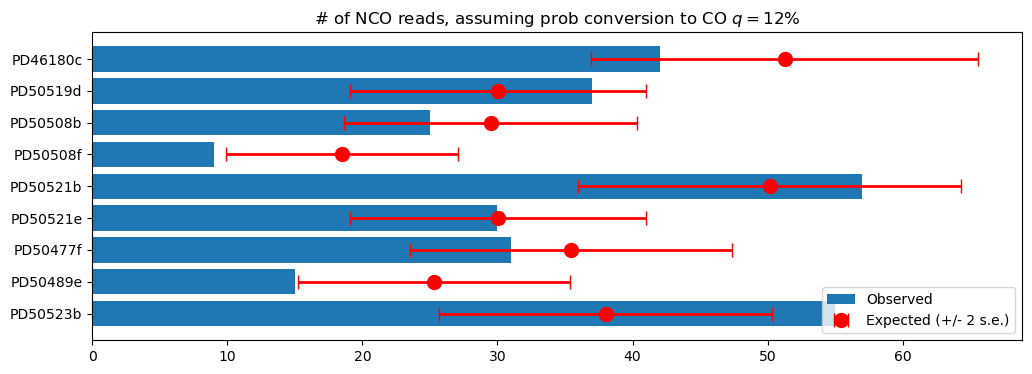

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

for i, sample_id in enumerate(sample_id_order):
    d = get_obs_exp(possible_NCO_subset_df.filter(pl.col("sample_id") == sample_id), 0.12)
    
    ax.barh(
        y = i,
        width = d["n_observed_NCOs"],
        color = "C0",        
    );
    
    ax.errorbar(
        x = d["mean_expected_NCOs"],
        y = i,
        xerr = d["std_expected_NCOs"] * 2,
        color = "red",
        ms = 10,
        fmt='o',
        elinewidth = 2,
        capsize = 5,
    );
    
ax.invert_yaxis()
ax.set_yticks(np.arange(len(sample_id_order)), sample_id_order);
ax.legend(["Observed", "Expected (+/- 2 s.e.)"]);
ax.set_title("# of NCO reads, assuming prob conversion to CO $q=12\%$");
    

# Check NCO differences between samples

In [14]:
sample_id_to_active_interval_lengths = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "GC"))
    )
    lens = sdf["CO_active_interval_crossover_prob"] * 1e2
    
    sample_id_to_active_interval_lengths[sample_id] = lens.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    lens_1 = sample_id_to_active_interval_lengths[sample_id1]
    lens_2 = sample_id_to_active_interval_lengths[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(lens_1), 
            len(lens_2),
            scipy.stats.ks_2samp(lens_1, lens_2).pvalue,
            inference.permutation_testing([[lens_1, lens_2]], 1000),
        ]
    )
    
pairwise_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "lens_ks_pvalue", 
            "lens_AD_perm_pvalue", ],
)    

100%|██████████| 36/36 [00:06<00:00,  5.51it/s]


In [15]:
pairwise_nco_df.sort("lens_AD_perm_pvalue")

sample_id1,sample_id2,n1,n2,lens_ks_pvalue,lens_AD_perm_pvalue
str,str,i64,i64,f64,f64
"""PD50519d""","""PD50521b""",68,74,0.002127,0.0
"""PD50519d""","""PD50521e""",68,49,0.000214,0.0
"""PD46180c""","""PD50519d""",60,68,0.006047,0.003
"""PD50508b""","""PD50519d""",42,68,0.017833,0.005
"""PD50519d""","""PD50523b""",68,76,0.006788,0.006
"""PD50508f""","""PD50519d""",28,68,0.046101,0.043
"""PD50489e""","""PD50521e""",38,49,0.031261,0.055
"""PD50477f""","""PD50521e""",56,49,0.08231,0.072
"""PD50477f""","""PD50519d""",56,68,0.07904,0.09


## Present this as a matrix

In [16]:
mat = []
for sample_id1 in sample_id_order:
    row = []
    for sample_id2 in sample_id_order:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_nco_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["lens_AD_perm_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
mat = pd.DataFrame(mat, index=sample_id_order, columns=sample_id_order)

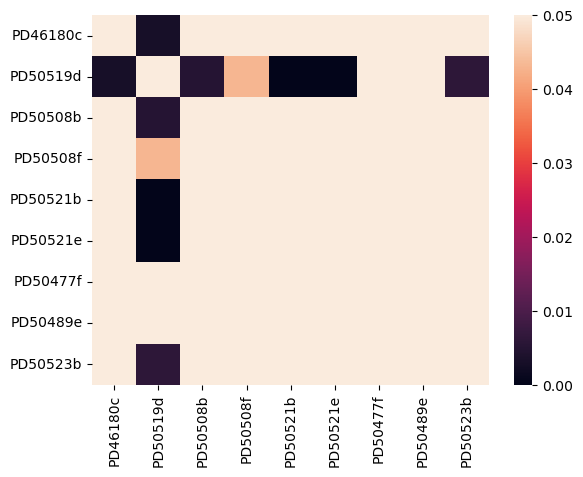

In [17]:
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
);

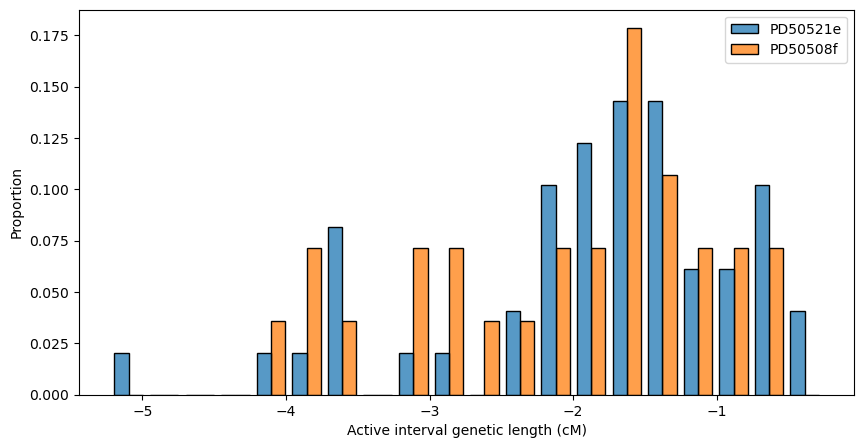

In [18]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id1 = "PD50521e"
sample_id2 = "PD50508f"

sns.histplot(
    [
        pd.Series(np.log10(sample_id_to_active_interval_lengths[sample_id1]), name=sample_id1),
        pd.Series(np.log10(sample_id_to_active_interval_lengths[sample_id2]), name=sample_id2),
    ], 
    bins=20, 
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length (cM)");


# Test one sample vs the rest

## Sample level

In [19]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    pairs = [
        [
            sample_id_to_active_interval_lengths[sample_id],
            sample_id_to_active_interval_lengths[other_sample_id],
        ]
        for other_sample_id in sample_ids if other_sample_id != sample_id 
    ]
    lens_1 = sample_id_to_active_interval_lengths[sample_id]
    rows.append(
        [
            sample_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
sample_vs_rest_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_in_sample", "AD_perm_pvalue"],
)

100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


In [20]:
sample_vs_rest_df.sort("AD_perm_pvalue")

sample_id,n_in_sample,AD_perm_pvalue
str,i64,f64
"""PD50519d""",68,0.0
"""PD50521e""",49,0.003
"""PD50521b""",74,0.075
"""PD50508b""",42,0.268
"""PD50489e""",38,0.301
"""PD50523b""",76,0.315
"""PD46180c""",60,0.362
"""PD50477f""",56,0.411
"""PD50508f""",28,0.87


## Group level

In [21]:
group_id_to_active_interval_lengths = {}

for group_id in group_id_order:
    group_id_to_active_interval_lengths[group_id] = np.concatenate([
        sample_id_to_active_interval_lengths[sample_id]
        for sample_id, v in sample_id_to_group_id.items() if v == group_id
    ])

In [22]:
rows = []
for group_id in tqdm.tqdm(sorted(group_id_order)):
    pairs = [
        [
            group_id_to_active_interval_lengths[group_id],
            group_id_to_active_interval_lengths[other_group_id],
        ]
        for other_group_id in group_id_order if other_group_id != group_id 
    ]
    lens_1 = group_id_to_active_interval_lengths[group_id]
    rows.append(
        [
            group_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
group_vs_rest_df = pl.DataFrame(
    rows,
    schema=["group_id", "n_in_group", "AD_perm_pvalue"],
)

100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


In [23]:
group_vs_rest_df.sort("AD_perm_pvalue")

group_id,n_in_group,AD_perm_pvalue
str,i64,f64
"""PD50521be""",123,0.005
"""PD46180c_PD50519d""",128,0.007
"""PD50508bf""",70,0.293
"""PD50489e""",38,0.439
"""PD50523b""",76,0.489
"""PD50477f""",56,0.652


# Add annotation for NCO reads only

In [24]:
NCO_df = (dense_reads_with_detection_df
    .filter(pl.col("class") == "GC")
    .with_columns(
        grch37_active_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_active_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_active_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_active_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
    )
    .with_columns(
        grch37_active_region_length = pl.col("grch37_active_end_pos") - pl.col("grch37_active_start_pos"),                
        grch38_active_region_length = pl.col("grch38_active_end_pos") - pl.col("grch38_active_start_pos"),                
    )
)

dfs = []
for [chrom], df in NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_active_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_active_start_pos"]) * 1e2,
            grch37_active_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_active_end_pos"]) * 1e2,
        ).with_columns(
            grch37_active_cM = (pl.col("grch37_active_end_poses_cm") - pl.col("grch37_active_start_poses_cm")),
            grch37_cM_per_bp_across_active = (pl.col("grch37_active_end_poses_cm") - pl.col("grch37_active_start_poses_cm")) / pl.col("grch37_active_region_length"),
        )
    )
    
NCO_df = pl.concat(dfs)

# DSBs

## Overall rates

### A/A

In [48]:
print("Fraction of NCO reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .filter(pl.col("class") == "GC")
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of NCO reads with motif in them: 0.55625


In [49]:
print("Fraction of all reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of all reads with motif in them: 0.14518942855367487


In [50]:
print("Fraction of NCO reads with motif in active region:", (NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .select(
        (pl.col("grch38_active_start_pos") <= pl.col("AA_motif_center_pos")) &
        (pl.col("grch38_active_end_pos") > pl.col("AA_motif_center_pos"))
    )
    .mean().item(0,0)
))

Fraction of NCO reads with motif in active region: 0.6179775280898876


### C/L4

In [51]:
print("Fraction of NCO reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .filter(pl.col("class") == "GC")
    .select(pl.col("CL4_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of NCO reads with motif in them: 0.09375


In [52]:
print("Fraction of all reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .select(pl.col("CL4_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of all reads with motif in them: 0.04200448474258069


In [53]:
print("Fraction of NCO reads with motif in active region:", (NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .select(
        (pl.col("grch38_active_start_pos") <= pl.col("CL4_motif_center_pos")) &
        (pl.col("grch38_active_end_pos") > pl.col("CL4_motif_center_pos"))
    )
    .mean().item(0,0)
))

Fraction of NCO reads with motif in active region: 0.2


## Overall distances to motif center

### Using the whole recombining interval

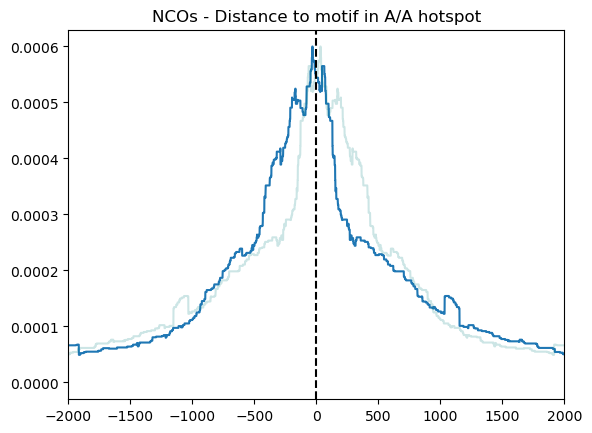

In [31]:
xs, H = inference.calculate_motif_distance_histogram(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

plt.plot(xs, H);
plt.plot(xs, H[::-1], color="teal", alpha=0.2);
plt.title("NCOs - Distance to motif in A/A hotspot");
plt.xlim(-2000,2000);
plt.axvline(0, color="black", ls="--");

In [32]:
inference.motif_distance_histogram_symmetry_permutation_testing(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

0.007

### Use just converted SNPs

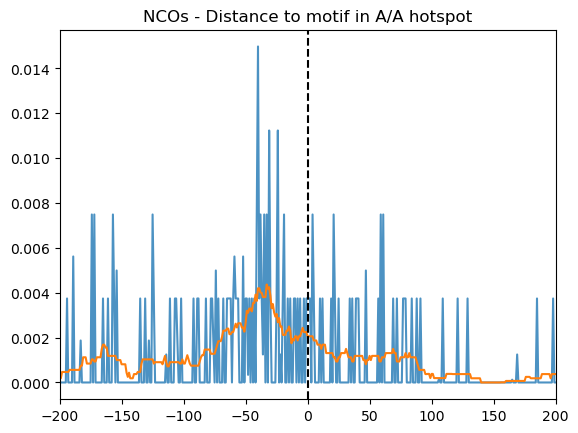

In [33]:
xs, H = inference.calculate_motif_distance_to_converted_snps_histogram(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

plt.plot(xs, H, alpha=0.8);
plt.plot(
    xs,
    scipy.ndimage.uniform_filter1d(H, 20),
)
#plt.plot(xs, H[::-1], color="teal", alpha=0.2);
plt.title("NCOs - Distance to motif in A/A hotspot");
plt.xlim(-200,200);
plt.axvline(0, color="black", ls="--");

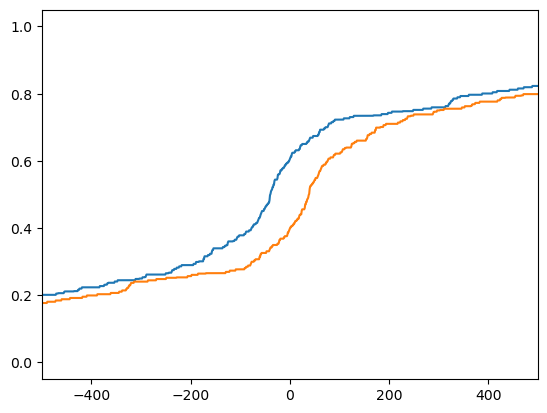

In [34]:
plt.plot(xs, np.cumsum(H));
plt.plot(xs, np.cumsum(H[::-1]));
plt.xlim(-500,500);


In [35]:
inference.motif_distance_histogram_symmetry_permutation_testing(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    max_dist=30000,
    n_perms=10000,
    hist_func = inference.calculate_motif_distance_to_converted_snps_histogram,
    stat = "max_sq_cumsum",
)

0.0009

## Distance to motif centers, per sample

### Using whole recombining interval

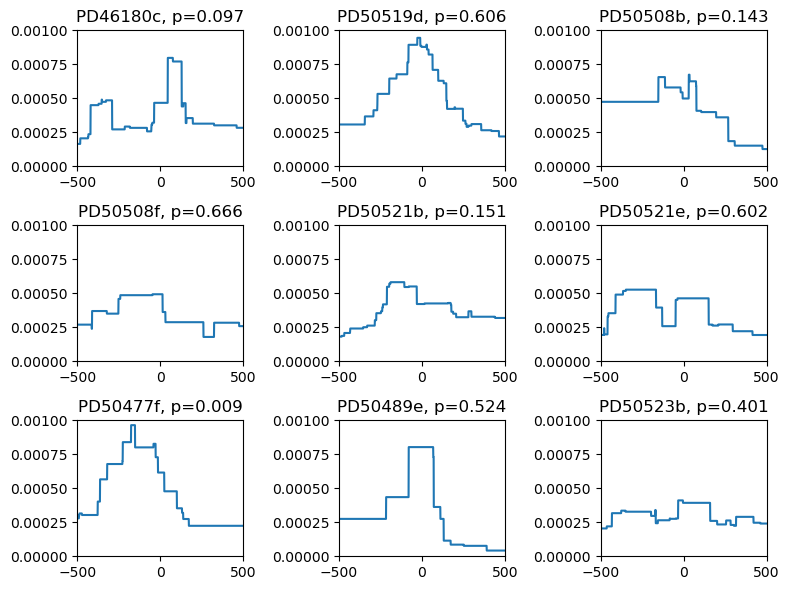

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(8, 6))

motif_distances_per_sample_id = {}

for ax, sample_id in zip(axs.ravel(), sample_id_order):
    xs, H = inference.calculate_motif_distance_histogram(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id)
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    pval = inference.motif_distance_histogram_symmetry_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id) 
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    motif_distances_per_sample_id[sample_id] = H

    ax.plot(xs, H, label=sample_id);
    ax.set_title(f"{sample_id}, p={pval}")
    ax.set_xlim(-500, 500)
    ax.set_ylim(0, 0.001);

fig.tight_layout()

### Using just converted SNPs

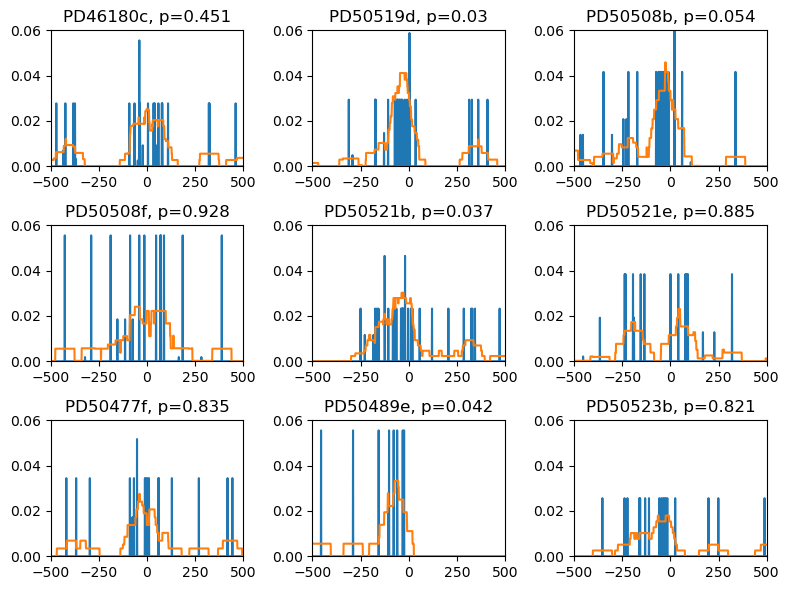

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(8, 6))

motif_distances_per_sample_id = {}

for ax, sample_id in zip(axs.ravel(), sample_id_order):
    xs, H = inference.calculate_motif_distance_to_converted_snps_histogram(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id)
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    pval = inference.motif_distance_histogram_symmetry_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id) 
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        hist_func = inference.calculate_motif_distance_to_converted_snps_histogram,
        n_perms = 1000,
        stat = "max_sq_cumsum",
    )
    
    motif_distances_per_sample_id[sample_id] = H

    ax.plot(xs, H, label=sample_id);
    ax.plot(xs, scipy.ndimage.uniform_filter1d(H, 100)*10, label=sample_id);
    
    ax.set_title(f"{sample_id}, p={pval}")
    ax.set_xlim(-500, 500)
    ax.set_ylim(0, 0.06);

fig.tight_layout()

# Compare distance to motif between samples, in NCOs

### Using whole converted 

In [38]:
rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id1))
        ),
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id2))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        n_perms=1000,
        stat="sum_abs",
    )
    
    rows.append(
        [
            sample_id1, 
            sample_id2,
            pval,
        ]
    )
    
pairwise_motif_dists_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "perm_pval"
           ],
)       

100%|██████████| 36/36 [00:56<00:00,  1.56s/it]


In [39]:
pairwise_motif_dists_nco_df.sort("perm_pval")

sample_id1,sample_id2,perm_pval
str,str,f64
"""PD50508b""","""PD50521b""",0.006
"""PD50508b""","""PD50523b""",0.031
"""PD50489e""","""PD50521b""",0.042
"""PD50508b""","""PD50521e""",0.043
"""PD50489e""","""PD50521e""",0.054
"""PD46180c""","""PD50508b""",0.062
"""PD50477f""","""PD50523b""",0.068
"""PD50477f""","""PD50489e""",0.078
"""PD50508b""","""PD50508f""",0.092


### Using converted SNPs

In [40]:
rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id1))
        ),
        (NCO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id2))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        hist_func = inference.calculate_motif_distance_to_converted_snps_histogram,
        n_perms = 1000,
        stat = "max_sq_cumsum",
    )
    
    rows.append(
        [
            sample_id1, 
            sample_id2,
            pval,
        ]
    )
    
pairwise_motif_dists_nco_only_snps_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "perm_pval"
           ],
)       

100%|██████████| 36/36 [01:03<00:00,  1.76s/it]


In [41]:
pairwise_motif_dists_nco_only_snps_df.sort("perm_pval")[:10]

sample_id1,sample_id2,perm_pval
str,str,f64
"""PD50521b""","""PD50523b""",0.069
"""PD50489e""","""PD50521e""",0.096
"""PD50508b""","""PD50521e""",0.163
"""PD50519d""","""PD50521e""",0.199
"""PD50521b""","""PD50521e""",0.201
"""PD50519d""","""PD50523b""",0.204
"""PD50477f""","""PD50489e""",0.231
"""PD50489e""","""PD50519d""",0.247
"""PD46180c""","""PD50523b""",0.261


# Compare DSB signal strengths between NCOs

In [54]:
sample_id_to_AA_heats = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter(pl.col("grch38_reference_start").is_not_null())
        .filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "GC"))
    )
    heats = sdf["AA_heat"].fill_null(0)
    sample_id_to_AA_heats[sample_id] = heats.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    heats_1 = sample_id_to_AA_heats[sample_id1]
    heats_2 = sample_id_to_AA_heats[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(heats_1), 
            len(heats_2),
            scipy.stats.ks_2samp(heats_1, heats_2).pvalue,
            inference.permutation_testing([[heats_1, heats_2]], 1000),
            inference.permutation_testing([[heats_1[heats_1>0], heats_2[heats_2>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_1==0).sum(), (heats_1!=0).sum()],
                 [(heats_2==0).sum(), (heats_2!=0).sum()]],
            ).pvalue,
        ]
    )
    
pairwise_AA_heats_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

100%|██████████| 36/36 [00:11<00:00,  3.25it/s]


In [55]:
pairwise_AA_heats_nco_df.sort("heats_AD_perm_pvalue")

sample_id1,sample_id2,n1,n2,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,str,i64,i64,f64,f64,f64,f64
"""PD50519d""","""PD50521b""",67,68,0.142288,0.093,0.445,0.166066
"""PD50521b""","""PD50523b""",68,76,0.398333,0.173,0.934,0.178532
"""PD46180c""","""PD50519d""",59,67,0.298964,0.193,0.462,0.28348
"""PD50489e""","""PD50521b""",37,68,0.460461,0.237,0.533,0.15536
"""PD50508f""","""PD50519d""",28,67,0.574278,0.269,0.367,0.263737
"""PD46180c""","""PD50489e""",59,37,0.566854,0.301,0.75,0.291934
"""PD46180c""","""PD50523b""",59,76,0.398889,0.304,0.885,0.297161
"""PD50477f""","""PD50521b""",55,68,0.487137,0.31,0.886,0.272296
"""PD50508f""","""PD50523b""",28,76,0.726052,0.31,0.58,0.272711


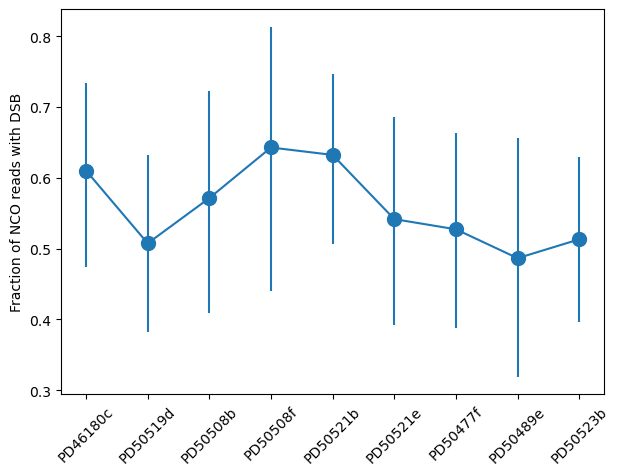

In [56]:
fig, ax = plt.subplots(figsize=(7,5))

mns = [(sample_id_to_AA_heats[s]>0).mean() for s in sample_id_order]
cis = [statsmodels.stats.proportion.proportion_confint(
    (sample_id_to_AA_heats[s]>0).sum(),
    len(sample_id_to_AA_heats[s]),
    method="beta",
) for s in sample_id_order]
    


ax.errorbar(
    x = np.arange(len(sample_id_order)),
    y = mns,
    yerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis, mns)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis, mns)],
    ],
    fmt=".-",
    ms=20,
    
);
ax.set_xticks(ticks = np.arange(len(sample_id_order)), labels=sample_id_order, rotation=45);
ax.set_ylabel("Fraction of NCO reads with DSB");

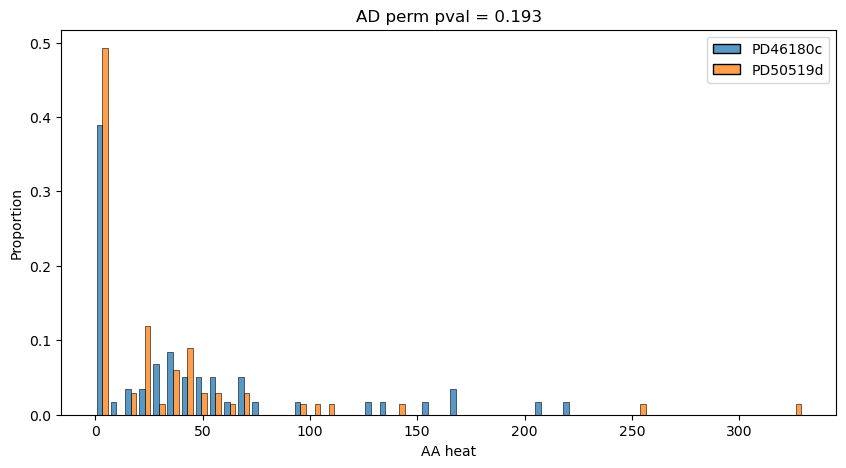

In [57]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id1 = "PD46180c"
sample_id2 = "PD50519d"

pval = pairwise_AA_heats_nco_df.filter(
    ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
    ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
)["heats_AD_perm_pvalue"].item(0)

sns.histplot(
    [
        pd.Series(sample_id_to_AA_heats[sample_id1], name=sample_id1),
        pd.Series(sample_id_to_AA_heats[sample_id2], name=sample_id2),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
plt.title(f"AD perm pval = {pval}");


# Test one sample vs the rest

## Sample level 

In [58]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    pairs = [
        [
            sample_id_to_AA_heats[sample_id],
            sample_id_to_AA_heats[other_sample_id],
        ]
        for other_sample_id in sample_ids if other_sample_id != sample_id 
    ]
    lens_1 = sample_id_to_AA_heats[sample_id]
    rows.append(
        [
            sample_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
sample_vs_rest_nco_AA_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_in_sample", "AD_perm_pvalue"],
)

100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


In [59]:
sample_vs_rest_nco_AA_df.sort("AD_perm_pvalue")

sample_id,n_in_sample,AD_perm_pvalue
str,i64,f64
"""PD50521b""",68,0.505
"""PD50519d""",67,0.618
"""PD46180c""",59,0.776
"""PD50508f""",28,0.793
"""PD50489e""",37,0.876
"""PD50523b""",76,0.899
"""PD50508b""",42,0.948
"""PD50477f""",55,0.974
"""PD50521e""",48,0.994
